# 833-JinxML - Predict Time

## Load Dataset

In [74]:
from tlol.datasets.replay_dataset import *
dataset = TLoLReplayDataset("./full_db")

## Dataset

In [109]:
tm_x_s = []
tm_y_s = []

for i in range(10): # len(dataset)
    cur  = dataset[i]
    tm_x = np.array([cur["raw"].iloc[:, 0:1]]) / 300.0
    tm_x = torch.Tensor(tm_x)

    tm_y = np.array([cur["raw"].iloc[:, 0:1]]) / 300.0
    tm_y = torch.Tensor(tm_y)
    
    tm_x_s.append(tm_x)
    tm_y_s.append(tm_y)

tm_x_s[0].shape

torch.Size([1, 1410, 1])

## Model

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

seed = 1
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

class TimePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

model = TimePredictor()

## Training

1000 0.03456002473831177 tensor([[[  5.2597],
         [  6.3354],
         [  6.5277],
         ...,
         [299.2676],
         [299.5605],
         [300.0000]]]) tensor([[[  5.2597],
         [  6.3354],
         [  6.5277],
         ...,
         [299.2676],
         [299.5605],
         [300.0000]]]) tensor([[[ 85.5556],
         [ 85.8839],
         [ 85.9427],
         ...,
         [190.0158],
         [190.1176],
         [190.2701]]], grad_fn=<MulBackward0>)
2000 0.01589590311050415 tensor([[[  5.2597],
         [  6.3354],
         [  6.5277],
         ...,
         [299.2676],
         [299.5605],
         [300.0000]]]) tensor([[[  5.2597],
         [  6.3354],
         [  6.5277],
         ...,
         [299.2676],
         [299.5605],
         [300.0000]]]) tensor([[[ 63.5470],
         [ 63.9872],
         [ 64.0661],
         ...,
         [224.0505],
         [224.1859],
         [224.3886]]], grad_fn=<MulBackward0>)
3000 0.005746289622038603 tensor([[[  5.2597],
   

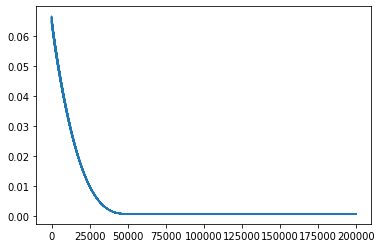

In [124]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda.amp.grad_scaler import GradScaler

criterion = nn.MSELoss()
lr = 0.0001 # 0.0001 # 
optimizer = optim.Adam(model.parameters(), lr=lr)
batch_size = 32

device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=False,
    pin_memory=(device=="cuda"),
    num_workers=6,
    batch_size=batch_size,
    collate_fn=dataset.collate_fixed_length)

amp = False
scaler = GradScaler()

n_epochs = 20_000

losses = []

for epoch in range(1, n_epochs + 1):
    for tm_x, tm_y in zip(tm_x_s, tm_y_s):
        optimizer.zero_grad()

        tm_x = tm_x.to(device)
        tm_y = tm_y.to(device)

        preds = model(tm_x)

        # print(preds, tm_x, tm_y)

        loss = criterion(preds, tm_y)
        losses.append(loss.detach().numpy())
        
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        print(epoch, loss.item(), tm_x * 300, tm_y * 300, preds * 300)

plt.plot(losses)